In [1]:
import torch
from basic_unet import UNet
from testnet import load_dataset
import matplotlib.pyplot as plt
from rise import RISE
from pathlib import Path

In [2]:
batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size)
model = UNet(in_channels=1, out_channels=1)
state_dict = torch.load('models/2_testnet_0490.pth')
model.load_state_dict(state_dict)
model = model.to(device)

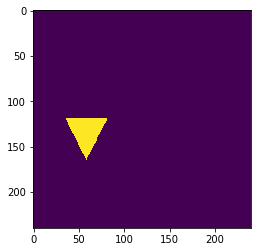

In [3]:
for sample in test_loader:
    segment = sample['segment']
    segment = segment.squeeze()
    plt.imshow(segment)
    plt.show()

    image = sample['input'].to(device)
    break

In [4]:
class SegmentationRISE(RISE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        _, _, H, W = x.size()

        # if a mask overlaps with the segment, do not apply this mask
        filtered_masks = []
        normalized_segment = (segment / segment.max()).to(device)
        for mask in explainer.masks:
            mask = mask.squeeze()
            combined = mask + normalized_segment
            if combined.max() < 1.001:
                filtered_masks.append(mask.unsqueeze(0))
        filtered_masks = torch.stack(filtered_masks)
        filtered_masks = filtered_masks[:3000]

        mask_count = len(filtered_masks)
        print('mask_count', mask_count)

        # generate new images by putting mask on top of original image
        stack = torch.mul(filtered_masks, x.data)

        output = model(x).squeeze()
        output = (output > output.mean())
        for x in range(output.shape[0]):
            for y in range(output.shape[1]):
                if output[x][y]:
                    # run generated images through the model
                    p = []
                    for i in range(0, mask_count, self.gpu_batch):
                        outputs_masked = self.model(stack[i:min(i + self.gpu_batch, mask_count)])
                        for output_masked in outputs_masked:
                            single_pixel = output_masked[x][y]
                            single_pixel = single_pixel.unsqueeze(0).unsqueeze(0)
                            p.append(single_pixel)
                    p = torch.cat(p)

                    # Number of classes
                    CL = p.size(1)

                    sal = torch.matmul(p.data.transpose(0, 1), filtered_masks.view(mask_count, H * W))

                    sal = sal.view((CL, H, W))
                    sal /= mask_count
                    return sal


masks_path = Path('rise_masks.npy')
explainer = SegmentationRISE(model, (240, 240), 10)
if not masks_path.exists():
    explainer.generate_masks(N=10000, s=8, p1=0.1, savepath=masks_path)
else:
    explainer.load_masks(masks_path)

with torch.set_grad_enabled(False):
    saliency = explainer(image).cpu().numpy()

mask_count 3000


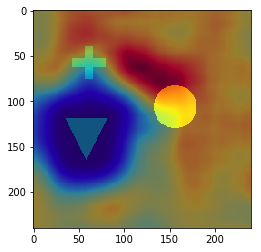

In [5]:
plt.imshow(image.cpu().squeeze())
plt.imshow(saliency[0], cmap='jet', alpha=0.5)
plt.show()